<a href="https://colab.research.google.com/github/ThamilOviyan/Heart-disease-prediction--pyspark/blob/main/Implementation_HDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**HEALTH CARE ANALYSIS:**
                **BY - 21MIA1033, 21MIA1042 & 21MIA1061**

**HEART DISEASE CLASSIFICATION**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=1866448e2fca60184c969153a2b0d58a08b75b01a3eb4236c16ddf85c8136c7b
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("heart_disease").getOrCreate()
spark

### **Reading Dataset and Creating Dataframe**

In [ ]:
df = spark.read.csv("/content/datasets_heart.csv", inferSchema=True, header=True)
df.show(5)
df.count()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
only showing top 5 rows



303

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [ ]:
df.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|  165|
|     0|  138|
+------+-----+



In [ ]:
from pyspark.sql.functions import *                                                  #checking whether dataframe has null values

def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
if null_columns_calc_list :
    spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()
else :
    print("Data is clean with no null values")

Data is clean with no null values


In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, MinMaxScaler             # Read in dependencies
from pyspark.sql.types import *
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.sql.functions import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [ ]:
def MLClassifierDFPrep(df,input_columns,dependent_var,treat_outliers=True,treat_neg_values=True):
    renamed = df.withColumn("label_str", df[dependent_var].cast(StringType()))          #Rename and change to string type
    indexer = StringIndexer(inputCol="label_str", outputCol="label")
    indexed = indexer.fit(renamed).transform(renamed)
    print(indexed.groupBy(dependent_var,"label").count().show(100))

    numeric_inputs = []
    string_inputs = []
    for column in input_columns:
        if str(indexed.schema[column].dataType) == 'StringType':
            indexer = StringIndexer(inputCol=column, outputCol=column+"_num")
            indexed = indexer.fit(indexed).transform(indexed)
            new_col_name = column+"_num"
            string_inputs.append(new_col_name)
        else:
            numeric_inputs.append(column)

    if treat_outliers == True:
        print("Correcting for non normality now!")
        d = {}                                                                          # empty dictionary d
        for col in numeric_inputs:                                                      # Create a dictionary of quantiles
            d[col] = indexed.approxQuantile(col,[0.01,0.99],0.25)
        for col in numeric_inputs:
            skew = indexed.agg(skewness(indexed[col])).collect()                        #check for skewness
            skew = skew[0][0]
            if skew > 1:
                indexed = indexed.withColumn(col, \
                log(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] ) +1).alias(col))
                print(col+" has been treated for positive (right) skewness. (skew =)",skew,")")
            elif skew < -1:
                indexed = indexed.withColumn(col, \
                exp(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] )).alias(col))
                print(col+" has been treated for negative (left) skewness. (skew =",skew,")")

    minimums = df.select([min(c).alias(c) for c in df.columns if c in numeric_inputs])   # Calculate the mins for all columns in the df
    min_array = minimums.select(array(numeric_inputs).alias("mins"))                     # Create an array for all mins and select only the input cols
    df_minimum = min_array.select(array_min(min_array.mins)).collect()                   # Collect global min as object
    df_minimum = df_minimum[0][0]                                                        # Slice to get the number itself

    features_list = numeric_inputs + string_inputs
    assembler = VectorAssembler(inputCols=features_list,outputCol='features')
    output = assembler.transform(indexed).select('features','label')

    if df_minimum < 0:
        print(" ")
        print("WARNING: The Naive Bayes Classifier will not be able to process the dataframe as it contains negative values")
        print(" ")

    if treat_neg_values == True:
        print("Opted to correct that by rescaling all features to a range of 0 to 1")
        print(" ")
        print("Rescaling the dataframe....")
        scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
        scalerModel = scaler.fit(output)                                                  # Compute summary statistics and generate MinMaxScalerModel
        scaled_data = scalerModel.transform(output)                                       # rescale each feature to range [min, max]
        final_data = scaled_data.select('label','scaledFeatures')                         # added class to the selection
        final_data = final_data.withColumnRenamed('scaledFeatures','features')
        print("Done!")

    else:
        print("Opted not to correct that therefore it will not be able to use to Naive Bayes classifier")
        print("Return the dataframe unscaled.")
        final_data = output

    return final_data


In [ ]:
def ClassTrainEval(classifier,features,classes,folds,train,test):
    def FindMtype(classifier):
        M = classifier
        Mtype = type(M).__name__
        return Mtype
    Mtype = FindMtype(classifier)
    def IntanceFitModel(Mtype,classifier,classes,features,folds,train):
        if Mtype == "OneVsRest":
            lr = LogisticRegression()                                                     # initiate the base classifier
            OVRclassifier = OneVsRest(classifier=lr)                                      #fitModel = OVRclassifier.fit(train)
            paramGrid = ParamGridBuilder() \
                .addGrid(lr.regParam, [0.1, 0.01]) \
                .build()
            crossval = CrossValidator(estimator=OVRclassifier,
                                      estimatorParamMaps=paramGrid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=folds)
            fitModel = crossval.fit(train)
            return fitModel
        if Mtype == "MultilayerPerceptronClassifier":
            features_count = len(features[0][0])
            layers = [features_count, features_count+1, features_count, classes]
            MPC_classifier = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
            fitModel = MPC_classifier.fit(train)
            return fitModel
        if Mtype in("LinearSVC","GBTClassifier") and classes != 2:
            print(Mtype," could not be used because PySpark currently only accepts binary classification data for this algorithm")
            return
        if Mtype in("LogisticRegression","NaiveBayes","RandomForestClassifier","GBTClassifier","LinearSVC","DecisionTreeClassifier"):

            if Mtype in("LogisticRegression"):
                paramGrid = (ParamGridBuilder() \
                             .addGrid(classifier.maxIter, [10, 15,20])
                             .build())

            if Mtype in("NaiveBayes"):
                paramGrid = (ParamGridBuilder() \
                             .addGrid(classifier.smoothing, [0.0, 0.2, 0.4, 0.6]) \
                             .build())

            if Mtype in("RandomForestClassifier"):
                paramGrid = (ParamGridBuilder() \
                               .addGrid(classifier.maxDepth, [2, 5, 10])
                             .build())

            if Mtype in("GBTClassifier"):
                paramGrid = (ParamGridBuilder() \
                             .addGrid(classifier.maxIter, [10, 15,50,100])
                             .build())

            if Mtype in("LinearSVC"):
                paramGrid = (ParamGridBuilder() \
                             .addGrid(classifier.maxIter, [10, 15]) \
                             .addGrid(classifier.regParam, [0.1, 0.01]) \
                             .build())

            if Mtype in("DecisionTreeClassifier"):
                paramGrid = (ParamGridBuilder() \
                             .addGrid(classifier.maxBins, [10, 20, 40, 80, 100]) \
                             .build())

            crossval = CrossValidator(estimator=classifier,
                                      estimatorParamMaps=paramGrid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=folds)
            fitModel = crossval.fit(train)
            return fitModel
    fitModel = IntanceFitModel(Mtype,classifier,classes,features,folds,train)

    if fitModel is not None:

        if Mtype in("OneVsRest"):
            BestModel = fitModel.bestModel
            global OVR_BestModel
            OVR_BestModel = BestModel
            print(" ")
            print('\033[1m' + Mtype + '\033[0m')
            models = BestModel.models
            for model in models:
                print('\033[1m' + 'Intercept: '+ '\033[0m',model.intercept)
                print('\033[1m' + 'Top 20 Coefficients:'+ '\033[0m')
                coeff_array = model.coefficients.toArray()
                coeff_scores = []
                for x in coeff_array:
                    coeff_scores.append(float(x))
                result = spark.createDataFrame(zip(input_columns,coeff_scores), schema=['feature','coeff'])
                print(result.orderBy(result["coeff"].desc()).show(truncate=False))


        if Mtype == "MultilayerPerceptronClassifier":
            print("")
            print('\033[1m' + Mtype + '\033[0m')
            print('\033[1m' + "Model Weights: "+ '\033[0m',fitModel.weights.size)
            print("")
            global MLPC_Model
            MLPC_BestModel = fitModel

        if Mtype in("DecisionTreeClassifier", "GBTClassifier","RandomForestClassifier"):
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype," Top 20 Feature Importances"+ '\033[0m')
            print("(Scores add up to 1)")
            print("Lowest score is the least important")
            print(" ")
            featureImportances = BestModel.featureImportances.toArray()

            imp_scores = []
            for x in featureImportances:
                imp_scores.append(float(x))

            result = spark.createDataFrame(zip(input_columns,imp_scores), schema=['feature','score'])
            print(result.orderBy(result["score"].desc()).show(truncate=False))

            if Mtype in("DecisionTreeClassifier"):
                global DT_featureimportances
                DT_featureimportances = BestModel.featureImportances.toArray()
                global DT_BestModel
                DT_BestModel = BestModel
            if Mtype in("GBTClassifier"):
                global GBT_featureimportances
                GBT_featureimportances = BestModel.featureImportances.toArray()
                global GBT_BestModel
                GBT_BestModel = BestModel
            if Mtype in("RandomForestClassifier"):
                global RF_featureimportances
                RF_featureimportances = BestModel.featureImportances.toArray()
                global RF_BestModel
                RF_BestModel = BestModel

        if Mtype in("LogisticRegression"):
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype + '\033[0m')
            print("Intercept: " + str(BestModel.interceptVector))
            print('\033[1m' + " Top 20 Coefficients"+ '\033[0m')
            print("You should compares these relative to eachother")
            coeff_array = BestModel.coefficientMatrix.toArray()
            coeff_scores = []
            for x in coeff_array[0]:
                coeff_scores.append(float(x))
            result = spark.createDataFrame(zip(input_columns,coeff_scores), schema=['feature','coeff'])
            print(result.orderBy(result["coeff"].desc()).show(truncate=False))
            global LR_coefficients
            LR_coefficients = BestModel.coefficientMatrix.toArray()
            global LR_BestModel
            LR_BestModel = BestModel

        if Mtype in("LinearSVC"):
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype + '\033[0m')
            print("Intercept: " + str(BestModel.intercept))
            print('\033[1m' + "Top 20 Coefficients"+ '\033[0m')
            print("You should compares these relative to eachother")
            coeff_array = BestModel.coefficients.toArray()
            coeff_scores = []
            for x in coeff_array:
                coeff_scores.append(float(x))
            result = spark.createDataFrame(zip(input_columns,coeff_scores), schema=['feature','coeff'])
            print(result.orderBy(result["coeff"].desc()).show(truncate=False))
            global LSVC_coefficients
            LSVC_coefficients = BestModel.coefficients.toArray()
            global LSVC_BestModel
            LSVC_BestModel = BestModel

    columns = ['Classifier', 'Result']

    if Mtype in("LinearSVC","GBTClassifier") and classes != 2:
        Mtype = [Mtype]
        score = ["N/A"]
        result = spark.createDataFrame(zip(Mtype,score), schema=columns)
    else:
        predictions = fitModel.transform(test)
        MC_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
        accuracy = (MC_evaluator.evaluate(predictions))*100
        Mtype = [Mtype]
        score = [str(accuracy)]
        result = spark.createDataFrame(zip(Mtype,score), schema=columns)
        result = result.withColumn('Result',result.Result.substr(0, 5))

    return result

### **Evaluate the Data**

In [ ]:
input_columns = df.columns
input_columns = input_columns[:-1]
dependent_var = 'target'
class_count = df.select(countDistinct("target")).collect()
classes = class_count[0][0]

In [ ]:
test1_data = MLClassifierDFPrep(df,input_columns,dependent_var)                       # Call on data prep, train and evaluate functions
test1_data.limit(5).toPandas()

classifiers = [                                                                       # Comment out Naive Bayes if data contains negative values
                LogisticRegression()
                ,OneVsRest()
               ,LinearSVC()
               ,NaiveBayes()
               ,RandomForestClassifier()
               ,GBTClassifier()
               ,DecisionTreeClassifier()
               ,MultilayerPerceptronClassifier()
              ]

train,test = test1_data.randomSplit([0.8,0.2])
features = test1_data.select(['features']).collect()
folds = 3

columns = ['Classifier', 'Result']                                                   #set up your results table
vals = [("Place Holder","N/A")]
results = spark.createDataFrame(vals, columns)

for classifier in classifiers:
    new_result = ClassTrainEval(classifier,features,classes,folds,train,test)
    results = results.union(new_result)
results = results.where("Classifier!='Place Holder'")
print("!!!!!Final Results!!!!!!!!")
results.show(100,False)

+------+-----+-----+
|target|label|count|
+------+-----+-----+
|     1|  0.0|  165|
|     0|  1.0|  138|
+------+-----+-----+

None
Correcting for non normality now!
chol has been treated for positive (right) skewness. (skew =) 1.1377326187082237 )
fbs has been treated for positive (right) skewness. (skew =) 1.9768034646834516 )
oldpeak has been treated for positive (right) skewness. (skew =) 1.2634255245891595 )
ca has been treated for positive (right) skewness. (skew =) 1.303925955673585 )
Opted to correct that by rescaling all features to a range of 0 to 1
 
Rescaling the dataframe....
Done!
 
LogisticRegression
Intercept: [-2.69844104731369]
 Top 20 Coefficients
You should compares these relative to eachother
+--------+--------------------+
|feature |coeff               |
+--------+--------------------+
|thal    |3.6962487520321594  |
|ca      |3.307549689323348   |
|trestbps|2.977222466391281   |
|chol    |2.933210499310889   |
|oldpeak |2.0681749006548893  |
|sex     |2.039691978

In [ ]:
result_column = results['Result']
classifier_column = results['Classifier']
results.show()

+--------------------+------+
|          Classifier|Result|
+--------------------+------+
|  LogisticRegression| 83.33|
|           OneVsRest| 83.33|
|           LinearSVC| 84.84|
|          NaiveBayes| 84.84|
|RandomForestClass...| 83.33|
|       GBTClassifier| 74.24|
|DecisionTreeClass...| 66.66|
|MultilayerPercept...| 71.21|
+--------------------+------+



In [ ]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

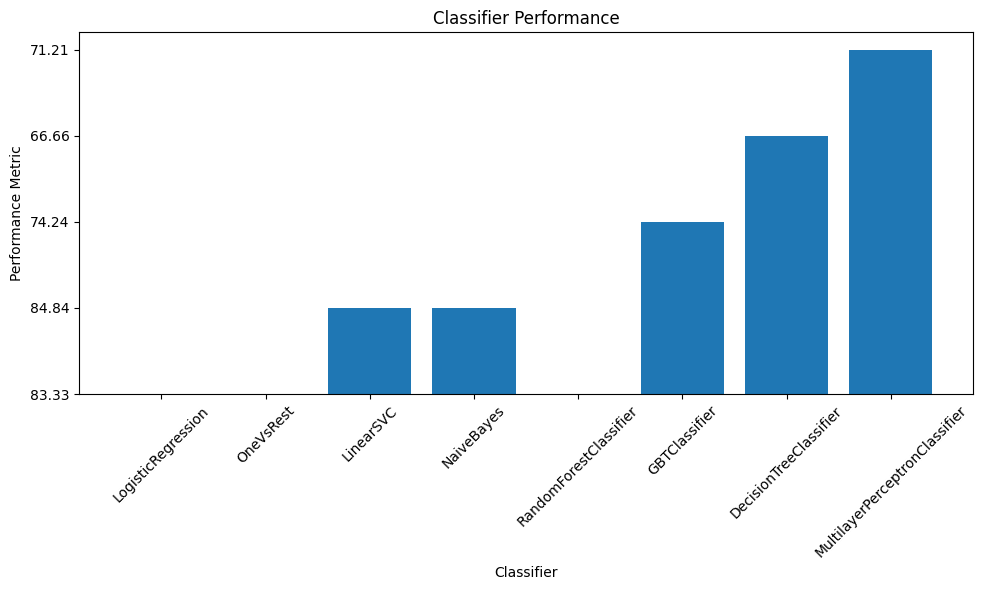

In [ ]:
results_dict = results.toPandas().set_index('Classifier')['Result'].to_dict()    # Assuming the 'results' DataFrame contains columns 'Classifier' and 'Result'
plt.figure(figsize=(10, 6))                                                      # and 'Result' is a string representation of the classifier's performance metric
plt.bar(results_dict.keys(), results_dict.values())
plt.xlabel('Classifier')
plt.ylabel('Performance Metric')
plt.title('Classifier Performance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

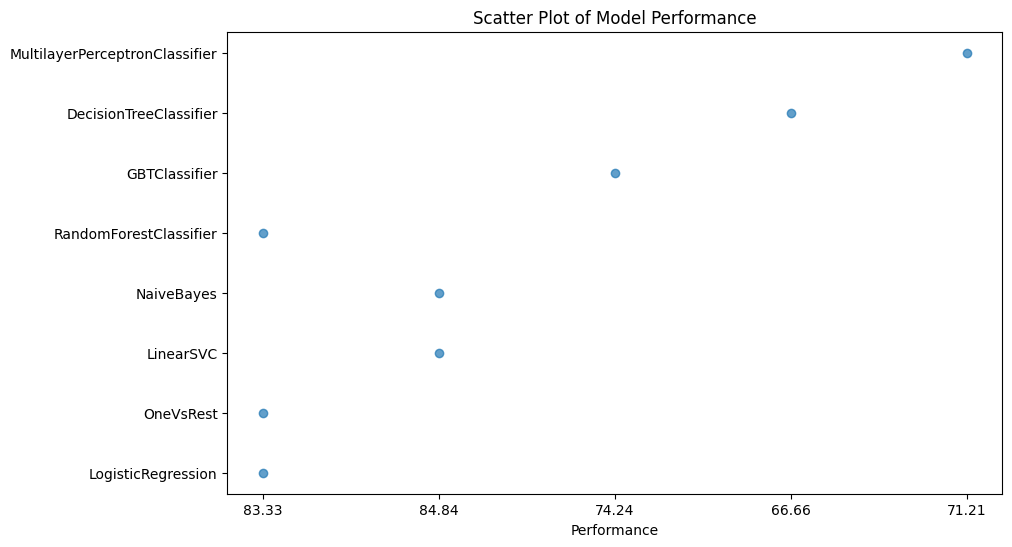

In [ ]:
# Create an index for each classifier
classifier_index = {classifier: i for i, classifier in enumerate(results_pd['Classifier'])}

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(results_pd['Result'], [classifier_index[classifier] for classifier in results_pd['Classifier']], alpha=0.7)
plt.yticks(range(len(classifiers)), results_pd['Classifier'])
plt.xlabel('Performance')
plt.title('Scatter Plot of Model Performance')
plt.show()


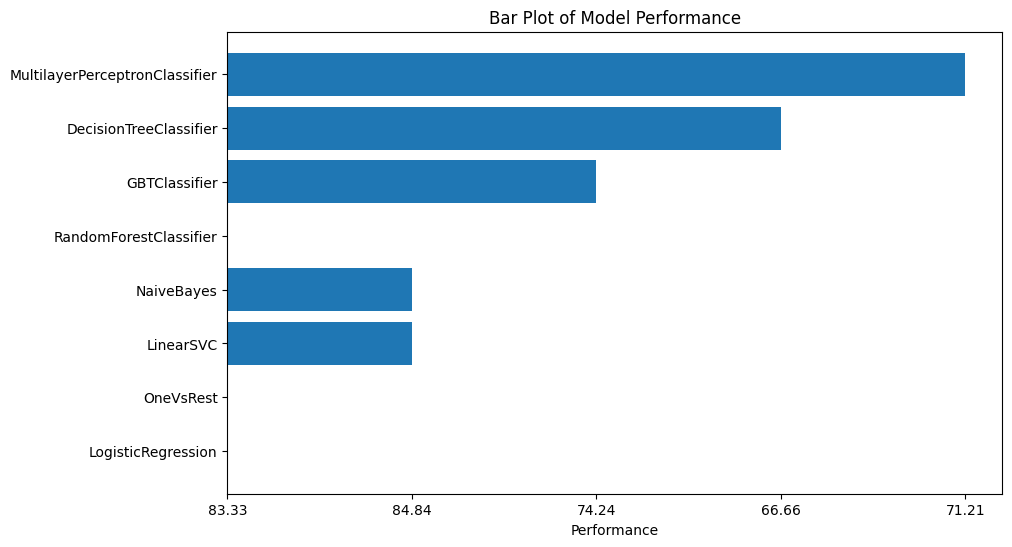

In [ ]:
# Bar plot
plt.figure(figsize=(10, 6))
plt.barh(results_pd['Classifier'], results_pd['Result'])
plt.xlabel('Performance')
plt.title('Bar Plot of Model Performance')
plt.show()


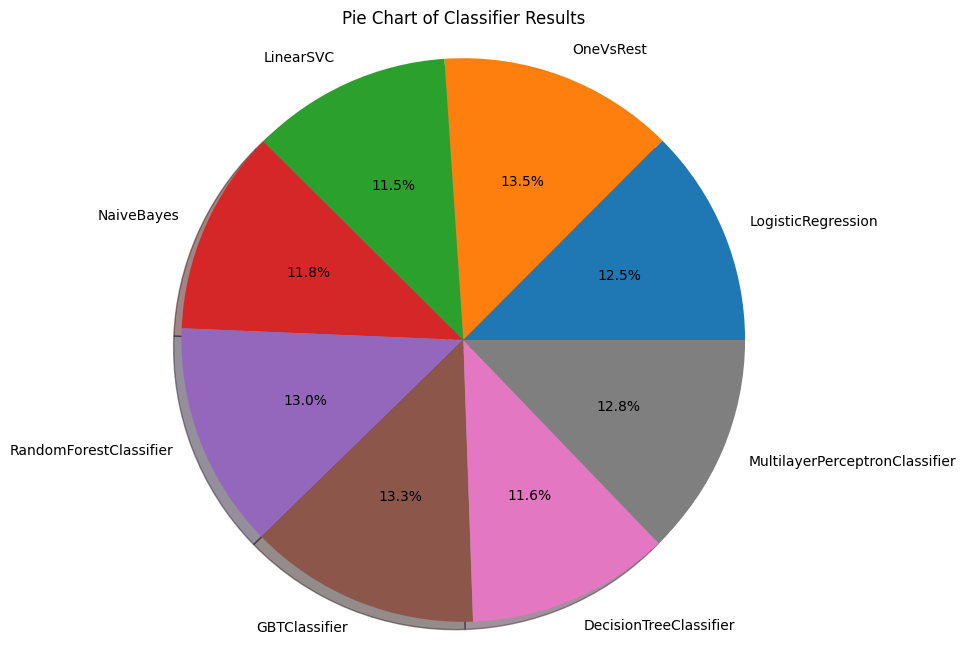

In [ ]:
import matplotlib.pyplot as plt

# Assuming your DataFrame 'results' contains the 'Result' and 'Classifier' columns
# Example data (replace this with your actual data)
classifiers = ['LogisticRegression', 'OneVsRest', 'LinearSVC', 'NaiveBayes', 'RandomForestClassifier', 'GBTClassifier', 'DecisionTreeClassifier', 'MultilayerPerceptronClassifier']
results = [85, 92, 78, 80, 88, 90, 79, 87]

plt.figure(figsize=(8, 8))
plt.pie(results, labels=classifiers, autopct='%1.1f%%', shadow=True)
plt.title('Pie Chart of Classifier Results')
plt.axis('equal')
plt.show()

### **Logistic Regression is performs well as its efficiency is good we perform it again for entire dataset.**

In [ ]:
predictions = LR_BestModel.transform(test)

In [ ]:
predictions.filter("prediction==1").show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[0.45833333333333...|[-0.2272001904610...|[0.44344303220932...|       1.0|
|  0.0|[0.77083333333333...|[-0.2593104047325...|[0.43553323353760...|       1.0|
|  0.0|[0.77083333333333...|[-1.0971932759943...|[0.25026615925250...|       1.0|
|  1.0|[0.27083333333333...|[-1.5188039160622...|[0.17963771637752...|       1.0|
|  1.0|[0.3125,1.0,0.0,0...|[-0.2633387269817...|[0.43454315299323...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
predictions.groupBy("label").count().show()
predictions.groupBy("prediction").count().show()
predictions.filter("prediction != label").count()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|   29|
|  1.0|   19|
+-----+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|   32|
|       1.0|   16|
+----------+-----+



9

In [ ]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

classifiers = [ LogisticRegression()
                ]
n = 99

selector = ChiSqSelector(numTopFeatures=n, featuresCol="features",
                     outputCol="selectedFeatures", labelCol="label")
bestFeaturesDf = selector.fit(test1_data).transform(test1_data)
bestFeaturesDf = bestFeaturesDf.select("label","selectedFeatures")
bestFeaturesDf = bestFeaturesDf.withColumnRenamed("selectedFeatures","features")

features = bestFeaturesDf.select(['features']).collect()

train,test = bestFeaturesDf.randomSplit([0.8,0.2])

folds = 3
columns = ['Classifier', 'Result']
vals = [("Place Holder","N/A")]
results = spark.createDataFrame(vals, columns)

for classifier in classifiers:
    new_result = ClassTrainEval(classifier,features,classes,folds,train,test)
    results = results.union(new_result)
results = results.where("Classifier!='Place Holder'")
results.show(100,False)

 
LogisticRegression
Intercept: [-3.089893771143971]
 Top 20 Coefficients
You should compares these relative to eachother
+--------+-------------------+
|feature |coeff              |
+--------+-------------------+
|ca      |4.128012107434977  |
|thal    |3.256883328332664  |
|trestbps|3.2232016780057062 |
|oldpeak |2.247919411591974  |
|sex     |1.9680482940056314 |
|exang   |1.256707974733641  |
|chol    |0.702808327198541  |
|fbs     |0.31085785995099624|
|slope   |-0.6789634987063682|
|age     |-0.9124735686451989|
|restecg |-1.5545063774043097|
|cp      |-3.3336257840557666|
|thalach |-3.6645094120417334|
+--------+-------------------+

None
+------------------+------+
|Classifier        |Result|
+------------------+------+
|LogisticRegression|73.13 |
+------------------+------+

